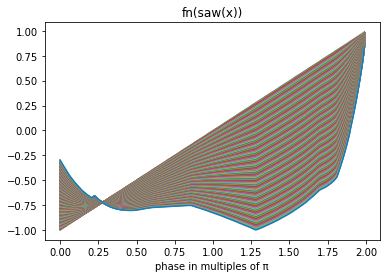

In [58]:
from matplotlib import pyplot as plt
import numpy as np
import random
#import pyaudio
import math
import struct
from scipy.signal import sawtooth, square

#CHANGEME

coefficient_range = [-1,1] #range of polynomial coefficients, too large might cause clicks
poly_degree = 10 #max degree of polynomials, too large might cause clicks

pieces = 10  #number of different polynomials to stitch together

sequence_length = 200  #Length of function sequence. 0 means identity function only. 
                      #Graphs will be plotted for sequence_length < 10 only.

frequency = 220
total_duration = 1000 #total duration of sound

waveform = "saw" #, "saw" , "tri" and "square" all work atm.


#INITIALISE

bitrate = 2**(10)
samplerate = 44100
step = 2/bitrate
A = np.arange(-1,1+step,step,dtype=float) #Range of possible amplitude values at chosen bitrate
size = A.size
functions = np.zeros(shape=(size,sequence_length+1))   #Rows 0,1,2,... are w, f_1(w), f_2(w), f_3(w),...,f_sequence(w) respectively.

#GENERATE CANDIDATE FUNCTIONS

functions[:,0] = A    #Row 0 is identity function

poly_intervals = np.sort(np.append(np.random.uniform(low=-1.0, high=1.0, size=pieces-1),[-1,1])) #the piecewise interval points

random_coefficients = np.random.uniform(low=coefficient_range[0], high=coefficient_range[1], size=(pieces,poly_degree)) #random matrix to draw polynomials from

final_curve = np.empty(shape=0) #final curve will be stored here

for i in range(pieces):
    last_piece_pos = 0
    x = np.arange(poly_intervals[i],poly_intervals[i+1], step)
    if i == 0:
        y = np.polyval(random_coefficients[i][:],x)
    else: 
        y = np.polyval(random_coefficients[i][:],x) - np.polyval(random_coefficients[i][:],poly_intervals[i]) + y[-1]  #glues next piece continuously onto previous piece
    final_curve = np.append(final_curve,y)

if final_curve.size > size:
    final_curve = final_curve[:(final_curve.size-size)*-1]  #makes sure endpoints match A

#final_curve = np.true_divide(final_curve, max(abs(final_curve))) #scales output to range (-1,1)
#final_curve /= np.max(np.abs(final_curve),axis=0)
final_curve = np.interp(final_curve, (final_curve.min(), final_curve.max()), (-1, +1))

functions[:,sequence_length] = final_curve

for interp in range(0,sequence_length+1):
    for function_domain in range(size):
        functions[function_domain,interp] = functions[function_domain,0] + interp * (functions[function_domain,sequence_length] - functions[function_domain,0])/sequence_length

#interp = sequence_length
#if sequence_length< 10: #doesn't produce a plot if sequence_length is too big - causes memory issues with Jupyter otherwise
#    plt.figure(interp)
#    plt.plot(A,functions[:,interp])
#    plt.title("Deformation Function f" + str(interp))
#    plt.xlabel('x')
#    plt.ylabel("f(x)")


def caller(x, interp):
    called_val = np.where(A == x)[0][0] #Returns the position of the input amplitude in the amplitude array A
    return(functions[called_val, interp])        #Outputs desired value f(x)

#AUDIO

def find_nearest(array, value):                #Allows any input to be rounded to the chosen bitrate, corresponding to a value in A
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def generate_sound(type, interp, frequency, volume, duration):

    outbuf = np.random.normal(loc=0, scale=1, size=int(float(duration / 1000.0)*samplerate))

    if type == "sine":
        dur = int(samplerate * float(duration / 1000.0))
        theta = 0.0
        incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
        for i in range(dur):
            outbuf[i] = caller(find_nearest(A,volume * math.sin(theta)),interp)
            theta += incr_theta
            
    if type == "saw":
        dur = int(samplerate * float(duration / 1000.0))
        theta = 0.0
        incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
        for i in range(dur):
            plotbuf[i] = caller(find_nearest(A,volume * sawtooth(theta)),interp)
            theta += incr_theta
            
    if type == "tri":
        dur = int(samplerate * float(duration / 1000.0))
        theta = 0.0
        incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
        for i in range(dur):
            plotbuf[i] = caller(find_nearest(A,volume * sawtooth(theta, width=0.5)),interp)
            theta += incr_theta    
            
    if type == "square":
        dur = int(samplerate * float(duration / 1000.0))
        theta = 0.0
        incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
        for i in range(dur):
            plotbuf[i] = caller(find_nearest(A,volume * square(theta)),interp)
            theta += incr_theta      

    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paFloat32, channels=1, rate=samplerate, output=True)
    data = b''.join(struct.pack('f', samp) for samp in outbuf) # must pack the binary data
    stream.write(data)
    stream.stop_stream()
    stream.close()
    
    #PLOT
    
    if sequence_length< 10: #doesn't produce a plot if sequence_length is too big - causes memory issues with Jupyter otherwise
        axes = np.arange(0,2,1/round(outbuf.size/frequency))
    
        plt.figure(interp)   #plots transformed sine wave on Deformation Function graph
        plt.plot(axes-1,outbuf[0:2*round(outbuf.size/frequency)])
    
        plt.figure(sequence_length+2)    #plots all sine waves on single graph
        plt.plot(axes,outbuf[0:2*round(outbuf.size/frequency)])
        plt.title("fn(sin(x))")
        plt.xlabel("phase in multiples of π")
    
    p.terminate()
    
def plotter(type, frequency, volume, duration):
    for interp in range(sequence_length+1):
        plotbuf = np.random.normal(loc=0, scale=1, size=int(float(duration / 1000.0)*samplerate))

        if type == "sine":
            dur = int(samplerate * float(duration / 1000.0))
            theta = 0.0
            incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
            for i in range(dur):
                plotbuf[i] = caller(find_nearest(A,volume * math.sin(theta)),interp)
                theta += incr_theta

        if type == "saw":
            dur = int(samplerate * float(duration / 1000.0))
            theta = 0.0
            incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
            for i in range(dur):
                plotbuf[i] = caller(find_nearest(A,volume * sawtooth(theta)),interp)
                theta += incr_theta

        if type == "tri":
            dur = int(samplerate * float(duration / 1000.0))
            theta = 0.0
            incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
            for i in range(dur):
                plotbuf[i] = caller(find_nearest(A,volume * sawtooth(theta, width = 0.5)),interp)
                theta += incr_theta     

        if type == "square":
            dur = int(samplerate * float(duration / 1000.0))
            theta = 0.0
            incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
            for i in range(dur):
                plotbuf[i] = caller(find_nearest(A,volume * square(theta)),interp)
                theta += incr_theta                   

        #PLOT

        #if sequence_length< 10: #doesn't produce a plot if sequence_length is too big - causes memory issues with Jupyter otherwise

        period_scale = sequence_length//2 #how many quarter-cycles to show. 4 = a single full cycle.

        axes = np.arange(0,2,1/period_scale/round(plotbuf.size/frequency))

        #plt.figure(interp)   #plots transformed sine wave on Deformation Function graph
        #plt.plot(axes-1,plotbuf[0:period_scale*2*round(plotbuf.size/frequency)])

        plt.figure(sequence_length+2)    #plots all sine waves on single graph
        plt.plot(axes,plotbuf[0:period_scale*2*round(plotbuf.size/frequency)])
        plt.title("fn(" + waveform + "(x))")
        plt.xlabel("phase in multiples of π")
    
def generate_sequence(type, frequency, volume, duration):

    outbuf = np.random.normal(loc=0, scale=1, size=int(float(duration * sequence_length / 1000.0)*samplerate))

    if type == "sine":
        dur = int(samplerate * float(duration / 1000.0)) #length of single fn(x)
        theta = 0.0
        incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
        for interp in range(sequence_length):
            for i in range(dur):
                outbuf[i + interp *dur - sequence_length - 1] = caller(find_nearest(A,volume * math.sin(theta)),interp)
                theta += incr_theta

    if type == "saw":
        dur = int(samplerate * float(duration / 1000.0))
        theta = 0.0
        incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
        for interp in range(sequence_length):
            for i in range(dur):
                outbuf[i + interp *dur - sequence_length - 1] = caller(find_nearest(A,volume * sawtooth(theta)),interp)
                theta += incr_theta

    if type == "tri":
        dur = int(samplerate * float(duration / 1000.0))
        theta = 0.0
        incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
        for interp in range(sequence_length):
            for i in range(dur):
                outbuf[i + interp *dur - sequence_length - 1] = caller(find_nearest(A,volume * sawtooth(theta, width = 0.5)),interp)
                theta += incr_theta                
                
    if type == "square":
        dur = int(samplerate * float(duration / 1000.0))
        theta = 0.0
        incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
        for interp in range(sequence_length):
            for i in range(dur):
                outbuf[i + interp *dur - sequence_length - 1] = caller(find_nearest(A,volume * square(theta)),interp)
                theta += incr_theta                  

    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paFloat32, channels=1, rate=samplerate, output=True)
    data = b''.join(struct.pack('f', samp) for samp in outbuf) # must pack the binary data
    stream.write(data)
    stream.stop_stream()
    stream.close()

        

single_duration = total_duration/sequence_length #duration of each sine wave

plotter(waveform, frequency, 1, single_duration) #plots if sequence_length < 10
#generate_sequence(waveform, frequency, 1, single_duration)  #  duration in milliseconds


In [7]:
np.random.uniform(low=-1.0, high=1.0, size=pieces-1)

array([ 0.23072843, -0.84126791,  0.6150294 ,  0.28155486,  0.73674002,
        0.26793353,  0.72504638,  0.91774359,  0.95802728])

In [59]:
with open(f'fns2.txt', 'w+') as f:
    for i in range(sequence_length):
        fn = functions[:,i]
        f.write('\t'.join(map(lambda x: '%.16f' % x, list(fn))))
        if i < sequence_length - 1:
            f.write('\n')

In [41]:
list(map(str, functions[:,0]))

['-1.0',
 '-0.998046875',
 '-0.99609375',
 '-0.994140625',
 '-0.9921875',
 '-0.990234375',
 '-0.98828125',
 '-0.986328125',
 '-0.984375',
 '-0.982421875',
 '-0.98046875',
 '-0.978515625',
 '-0.9765625',
 '-0.974609375',
 '-0.97265625',
 '-0.970703125',
 '-0.96875',
 '-0.966796875',
 '-0.96484375',
 '-0.962890625',
 '-0.9609375',
 '-0.958984375',
 '-0.95703125',
 '-0.955078125',
 '-0.953125',
 '-0.951171875',
 '-0.94921875',
 '-0.947265625',
 '-0.9453125',
 '-0.943359375',
 '-0.94140625',
 '-0.939453125',
 '-0.9375',
 '-0.935546875',
 '-0.93359375',
 '-0.931640625',
 '-0.9296875',
 '-0.927734375',
 '-0.92578125',
 '-0.923828125',
 '-0.921875',
 '-0.919921875',
 '-0.91796875',
 '-0.916015625',
 '-0.9140625',
 '-0.912109375',
 '-0.91015625',
 '-0.908203125',
 '-0.90625',
 '-0.904296875',
 '-0.90234375',
 '-0.900390625',
 '-0.8984375',
 '-0.896484375',
 '-0.89453125',
 '-0.892578125',
 '-0.890625',
 '-0.888671875',
 '-0.88671875',
 '-0.884765625',
 '-0.8828125',
 '-0.880859375',
 '-0.87890

In [47]:
len(functions[0,:])

513